Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive",force_remount=True)

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Updating the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/melanoma skin /Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/melanoma skin /Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
## Looking at the the list of files in the directory
#!ls

In [ ]:
## Checking the image count in train and test data sets
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


#### Load using keras.preprocessing

#### Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Writing the train dataset 
##  used seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
##  resizing images to the size img_height*img_width
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
## checking the validation dataset
## used seed=123 while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resized images to the size img_height*img_width
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
# Listing out all the classes of skin cancer and storing them in a list. 
# Checking the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualize one instance of all the nine classes present in the dataset

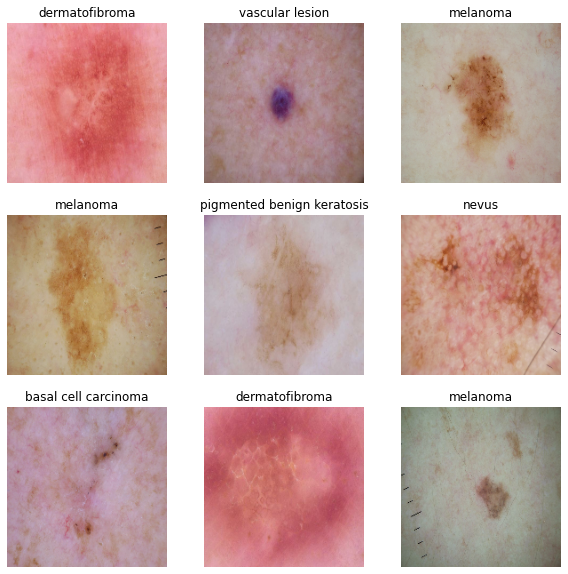

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

#### HERE WE CAN SEE WHICH SKIN DISEASE CONTAIN HOW MUCH DATA 

In [ ]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,squamous cell carcinoma,181
2,dermatofibroma,95
3,basal cell carcinoma,376
4,melanoma,438
5,nevus,357
6,pigmented benign keratosis,462
7,seborrheic keratosis,77
8,vascular lesion,139


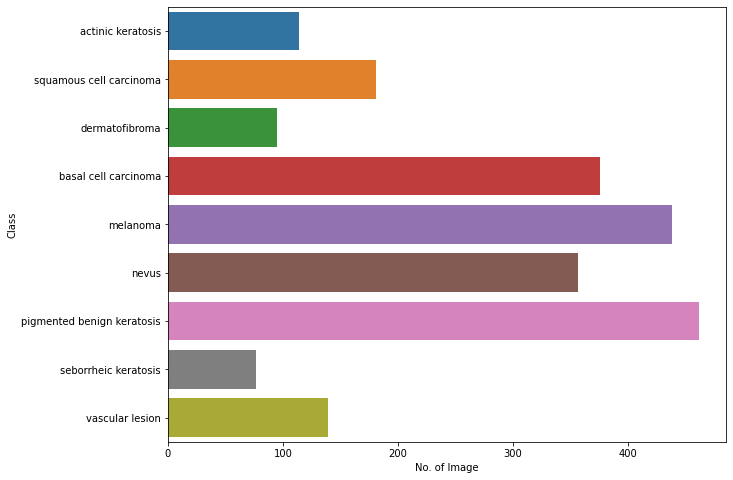

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

###Create the model

#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [ ]:
### Your code goes here
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### choose Sparse Categorical Crossentropy optimiser and relu loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 859s 1s/step - loss: 1.9888 - accuracy: 0.2548 - val_loss: 1.5978 - val_accuracy: 0.3890
Epoch 2/20
169/169 [==============================] - 4s 23ms/step - loss: 1.5334 - accuracy: 0.4097 - val_loss: 1.3999 - val_accuracy: 0.4796
Epoch 3/20
169/169 [==============================] - 3s 21ms/step - loss: 1.3252 - accuracy: 0.4980 - val_loss: 1.2210 - val_accuracy: 0.5553
Epoch 4/20
169/169 [==============================] - 3s 20ms/step - loss: 1.1218 - accuracy: 0.5823 - val_loss: 1.2695 - val_accuracy: 0.5471
Epoch 5/20
169/169 [==============================] - 3s 20ms/step - loss: 0.9784 - accuracy: 0.6380 - val_loss: 1.0815 - val_accuracy: 0.5924
Epoch 6/20
169/169 [==============================] - 5s 28ms/step - loss: 0.7851 - accuracy: 0.7133 - val_loss: 0.8648 - val_accuracy: 0.6904
Epoch 7/20
169/169 [==============================] - 4s 25ms/step - loss: 0.6421 - accuracy: 0.7704 - val_loss: 0.8269 - val_accuracy: 0.7030

### Visualizing training results

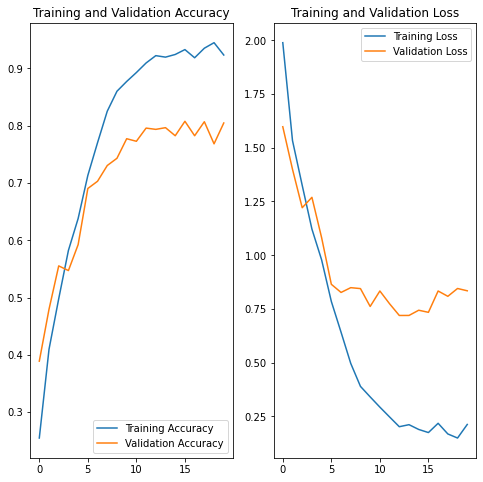

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Lets store the final accuracy in a dataframe for the consecutive training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
accuracy_history_df = pd.DataFrame(data=[{"Type":"Vanilla","Training Accuracy":acc[-1],"Validation Accuracy":val_acc[-1],"Epochs":epochs}])
accuracy_history_df

,Type,Training Accuracy,Validation Accuracy,Epochs
0,Vanilla,0.923405,0.804751,20


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

## Clearly the modelis underfitting as validation loss is too high when compared with training loss resulting in poor validation accuracy

In [ ]:
# data augumentation by flipping the images horizontally. 
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

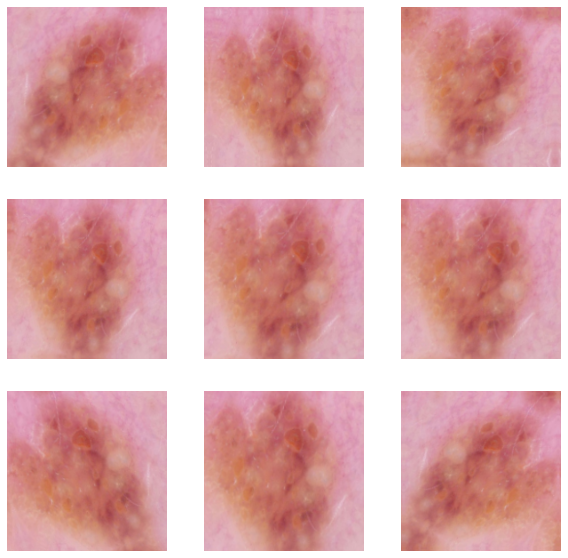

In [ ]:
# Visualize augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

##### Create the model, compile and train the model

In [ ]:
## Dropout layer introduced to tackle overfitting

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])




### Compiling the model

In [ ]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
## Training the model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


169/169 [==============================] - 32s 161ms/step - loss: 1.7724 - accuracy: 0.3340 - val_loss: 1.4522 - val_accuracy: 0.4469
Epoch 2/20
169/169 [==============================] - 27s 159ms/step - loss: 1.4594 - accuracy: 0.4486 - val_loss: 1.2978 - val_accuracy: 0.5078
Epoch 3/20
169/169 [==============================] - 28s 169ms/step - loss: 1.3548 - accuracy: 0.4915 - val_loss: 1.2334 - val_accuracy: 0.5048
Epoch 4/20
169/169 [==============================] - 27s 160ms/step - loss: 1.2517 - accuracy: 0.5304 - val_loss: 1.1381 - val_accuracy: 0.5546
Epoch 5/20
169/169 [==============================] - 27s 159ms/step - loss: 1.1780 - accuracy: 0.5644 - val_loss: 1.1503 - val_accuracy: 0.5798
Epoch 6/20
169/169 [==============================] - 27s 158ms/step - loss: 1.1377 - accuracy: 0.5727 - val_loss: 1.0965 - val_accuracy: 0.5731
Epoch 7/20
169/169 [==============================] - 27s 158ms/step - loss: 1.0796 - accuracy: 0.5922 - val_loss: 0.9888 - val_accuracy: 0.6

### Visualizing the results

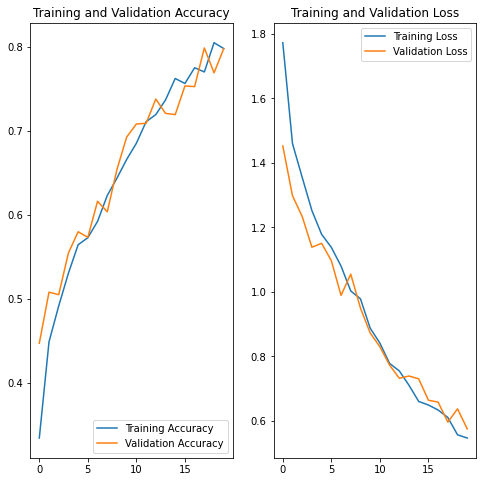

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Lets store the final accuracy in a dataframe for the consecutive training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
accuracy_history_df = pd.DataFrame(data=[{"Type":"Vanilla","Training Accuracy":acc[-1],"Validation Accuracy":val_acc[-1],"Epochs":epochs}])
accuracy_history_df

,Type,Training Accuracy,Validation Accuracy,Epochs
0,Vanilla,0.798034,0.79807,20


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

##There is an very good improvement from the previous model but still the model can be improved as there is substantial difference in training and validation loss and accuracy.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [ ]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/melanoma skin /Skin ca...,actinic keratosis
1,/content/gdrive/MyDrive/melanoma skin /Skin ca...,actinic keratosis
2,/content/gdrive/MyDrive/melanoma skin /Skin ca...,actinic keratosis
3,/content/gdrive/MyDrive/melanoma skin /Skin ca...,actinic keratosis
4,/content/gdrive/MyDrive/melanoma skin /Skin ca...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/melanoma skin /Skin ca...,vascular lesion
2235,/content/gdrive/MyDrive/melanoma skin /Skin ca...,vascular lesion
2236,/content/gdrive/MyDrive/melanoma skin /Skin ca...,vascular lesion
2237,/content/gdrive/MyDrive/melanoma skin /Skin ca...,vascular lesion


Class=0, n=114 (5.092%)
Class=7, n=181 (8.084%)
Class=2, n=95 (4.243%)
Class=1, n=376 (16.793%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=8, n=139 (6.208%)


<BarContainer object of 9 artists>

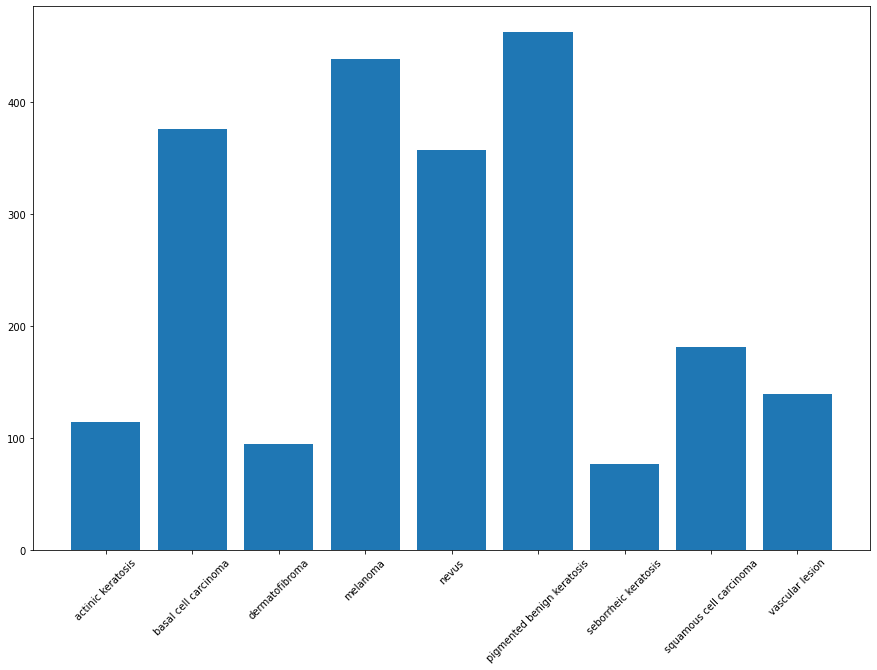

In [ ]:
### Checking the distribution of all the images category wise

from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(15,10))
plt.xticks(rotation=45)
plt.bar(class_names,count)

- Seborrheic keratosis is having the lowest distribution
- Pigmented Benign keratosis is having the highest distribution of data

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
path_to_training_dataset="/content/gdrive/MyDrive/melanoma skin /Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma skin /Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF772B08940>: 100%|██████████| 500/500 [00:20<00:00, 24.84 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma skin /Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF772ACFB80>: 100%|██████████| 500/500 [00:19<00:00, 25.99 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma skin /Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF7EBD368E0>: 100%|██████████| 500/500 [00:21<00:00, 23.63 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma skin /Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF772A743A0>: 100%|██████████| 500/500 [01:42<00:00,  4.88 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma skin /Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=962x674 at 0x7FF772AA5D90>: 100%|██████████| 500/500 [01:31<00:00,  5.49 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma skin /Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF772D306D0>: 100%|██████████| 500/500 [00:19<00:00, 25.68 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma skin /Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF76654B070>: 100%|██████████| 500/500 [00:46<00:00, 10.69 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma skin /Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF769D42C40>: 100%|██████████| 500/500 [00:21<00:00, 23.24 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma skin /Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF772BD1190>: 100%|██████████| 500/500 [00:19<00:00, 25.96 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/melanoma skin /Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030344.jpg_48732b0f-31c6-478f-8f80-81a649b899c0.jpg',
 '/content/gdrive/MyDrive/melanoma skin /Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032422.jpg_2dac690b-cc87-43bf-bd83-672f426e089d.jpg',
 '/content/gdrive/MyDrive/melanoma skin /Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031506.jpg_fc973a14-95c5-4452-a0c4-afa6e088a17e.jpg',
 '/content/gdrive/MyDrive/melanoma skin /Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026171.jpg_d8d2dce2-4526-4d62-ad4d-58a7fc7d4e52.jpg',
 '/content/gdrive/MyDrive/melanoma skin /Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
### Creating the new dataframe with path list and lesion list
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
### Concatenating the new dataframe with columns Path and label
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    1462
melanoma                      1438
basal cell carcinoma          1376
nevus                         1357
squamous cell carcinoma       1181
vascular lesion               1139
actinic keratosis             1114
dermatofibroma                1095
seborrheic keratosis          1077
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


### Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


### Create your model (make sure to include normalization)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

### Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

###  Train your model

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 [==============================] - 70s 97ms/step - loss: 1.9290 - accuracy: 0.2357 - val_loss: 1.6140 - val_accuracy: 0.3218
Epoch 2/30
281/281 [==============================] - 7s 25ms/step - loss: 1.5008 - accuracy: 0.4137 - val_loss: 1.4210 - val_accuracy: 0.4446
Epoch 3/30
281/281 [==============================] - 7s 24ms/step - loss: 1.3570 - accuracy: 0.4651 - val_loss: 1.3045 - val_accuracy: 0.5016
Epoch 4/30
281/281 [==============================] - 7s 24ms/step - loss: 1.2520 - accuracy: 0.5098 - val_loss: 1.2769 - val_accuracy: 0.4980
Epoch 5/30
281/281 [==============================] - 7s 25ms/step - loss: 1.1504 - accuracy: 0.5562 - val_loss: 1.1350 - val_accuracy: 0.5572
Epoch 6/30
281/281 [==============================] - 7s 23ms/step - loss: 1.0967 - accuracy: 0.5797 - val_loss: 1.0788 - val_accuracy: 0.5968
Epoch 7/30
281/281 [==============================] - 7s 24ms/step - loss: 0.9171 - accuracy: 0.6565 - val_loss: 0.9797 - val_accuracy: 0.648

### Visualize the model results

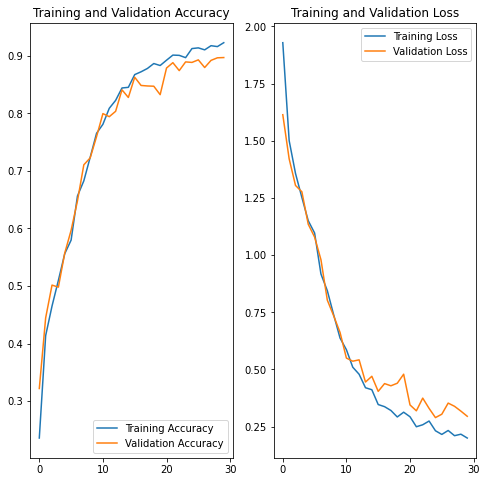

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Class rebalance has helped to improve the model and model is performing quite well without any overfitting and good accuracy.

In [ ]:
# Lets store the final accuracy in a dataframe for the consecutive training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
accuracy_history_df = pd.DataFrame(data=[{"Type":"Vanilla","Training Accuracy":acc[-1],"Validation Accuracy":val_acc[-1],"Epochs":epochs}])
accuracy_history_df

,Type,Training Accuracy,Validation Accuracy,Epochs
0,Vanilla,0.923043,0.897196,30
